In [1]:
#Objectives: 
#Nous allons parcourir la base de données de Mercedes Benz 
#Cette base de données contient les différentes options des voitures constuites,
#C'est variables sont d'écrites sous forme de variables anonymes
#La variable Y représente le temps qu'une voiture passe dans la borne de test 


In [2]:
# importer ici les librairies dont vous aurez besoin

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import check_array

from sklearn.metrics import r2_score

C:\anacanda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [4]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Récuperation des données, dimension des tableaux et 

In [5]:
#récuperation des données 
#données pour le train
data_train = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")


In [6]:
#dimension du train 
data_train.shape
print(data_train.shape)
print("on a, dans notre jeu de données, 4209 voitures, 378 options variables ")

(4209, 378)
on a, dans notre jeu de données, 4209 voitures, 378 options variables 


In [7]:
#dimension du test 
data_test.shape[0]


4209

In [8]:
data_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#print(data_train.isnull().sum())

In [10]:
#on peut voir qu'il y a pas de valeurs manquantes
print(data_train.isnull().sum().sum())

0


In [11]:
data_train.isnull().values.any()

False

In [12]:
data_train.head(10)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,t,b,e,c,d,g,h,s,...,0,0,1,0,0,0,0,0,0,0
6,24,128.76,al,r,e,f,d,f,h,s,...,0,0,0,0,0,0,0,0,0,0
7,25,91.91,o,l,as,f,d,f,j,a,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,w,s,as,e,d,f,i,h,...,1,0,0,0,0,0,0,0,0,0
9,30,126.99,j,b,aq,c,d,f,a,e,...,0,0,1,0,0,0,0,0,0,0


In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


On a 8 variables qualitatives et 369 variables boolein 

La variable Y est la variable temps passée par une voiture dans le branche de test pour chaque variable.
c'est la variable qu'on va prédir après 
   

In [14]:
dtype_data = data_train.dtypes.reset_index()
dtype_data.loc[:10,:]

,index,0
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


In [15]:
#data avec la variable reponse et les variables qualitatives 
#data_quant=data_train[["y","X0","X1","X2","X3","X4","X5","X6","X8"]]

In [16]:
#data_quant["X10"]

corr = data_quant.corr() # matrix de correlation
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,annot=True, vmax=.3)
plt.show()
# on peut s'apercevoir sur ce heatmap des corrélation que la variable "left"
# est le plus corrélé avec "time_spend_compagny" et average_monthly_hours
# et est négativement corrélé avec les varibles "satisfaction level " et "working_accident"

import seaborn as sns
corr = data_uant.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

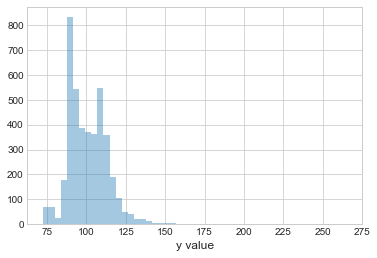

In [17]:
sns.distplot(data_train.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

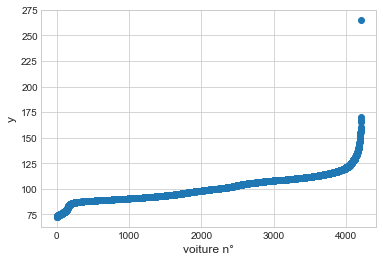

In [18]:
#on va voir la réaction de la variable Y
plt.scatter(range(data_train.shape[0]), np.sort(data_train.y.values))
plt.xlabel('voiture n°', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

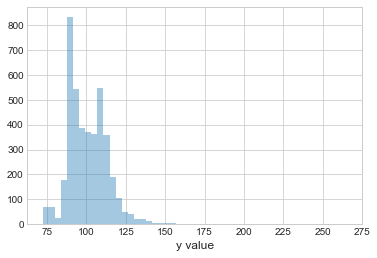

In [19]:

sns.distplot(data_train.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

In [20]:
data_train['X300'].value_counts()


0    3338
1     871
Name: X300, dtype: int64

In [21]:
#Données pour le test 
data_test = pd.read_csv("data/test.csv")

In [22]:
#dimension du frame 
data_test.shape

(4209, 377)

In [23]:
#data_test.head()

In [24]:
#exploration de la variable X0
data_train['X0'].value_counts()


z     360
ak    349
y     324
ay    313
t     306
x     300
o     269
f     227
n     195
w     182
j     181
az    175
aj    151
s     106
ap    103
h      75
d      73
al     67
v      36
af     35
m      34
ai     34
e      32
ba     27
at     25
a      21
ax     19
aq     18
i      18
am     18
u      17
aw     16
l      16
ad     14
b      11
k      11
au     11
as     10
r      10
bc      6
ao      4
c       3
aa      2
q       2
ac      1
g       1
ab      1
Name: X0, dtype: int64

unique_values_dict = {}
for col in data_train.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

In [25]:
#Extrere les colonnes des deux variables X10, X380
#data_train.ix[:,["X10","X380"]]

In [26]:
test=data_train.as_matrix()
#print(test[:,10:385])

In [27]:
#transfomer les objets en code numérique 

for c in data_train:
    if data_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(data_train[c].values)+list(data_test[c].values))
        data_train[c] = lbl.transform(list(data_train[c].values))
        data_test[c]= lbl.transform(list(data_test[c].values))
     


In [28]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(377)
memory usage: 12.1 MB


In [29]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(377)
memory usage: 12.1 MB


In [30]:
from sklearn.cross_validation import train_test_split

Y_train= data_train["y"].values
X_train= data_train.drop(["y","ID"], axis=1)
X_test = data_test.drop(["ID"], axis=1)



In [31]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(377)
memory usage: 12.1 MB


In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 376 entries, X0 to X385
dtypes: int64(376)
memory usage: 12.1 MB


data_train["eval_set"]

In [33]:
#Train the xgb model then predict the test data

model_1 = XGBRegressor(learning_rate=0.01, n_estimators=400, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =10)
model_1.fit(X_train, Y_train)

Y_predict = model_1.predict(X_test)

In [34]:
#utilisation du GradientBoostingRegressor
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, min_samples_leaf=18, min_samples_split=14, subsample=0.7)),
    LassoLarsCV()

)


stacked_pipeline.fit(X_train, Y_train)
results = stacked_pipeline.predict(X_test)

C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.025e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.597e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.597e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_it

C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.682e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.682e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.341e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_it

C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 71 iterations, i.e. alpha=1.970e-03, with an active set of 71 regressors, and the smallest cholesky pivot element being 4.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 77 iterations, i.e. alpha=1.758e-03, with an active set of 77 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\anacanda\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 77 iterations, i.e. alpha=1.758e-03, with an active set of 77 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce 

In [35]:
from sklearn import *

C:\anacanda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\anacanda\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [36]:
Y_predict

array([  79.56459808,   96.78109741,   80.06500244, ...,   91.22626495,
        107.25185394,   89.81809235], dtype=float32)

In [37]:
Y_predict.mean()

99.021088

In [38]:
#prediction du temps de test pour chaque ID 
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = Y_predict
sub.to_csv('xgbpred_model.csv', index=False)

In [39]:
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = Y_predict*0.6 + results*0.4
sub.to_csv('xgbpred&stacked_pipeline.csv', index=False)


In [40]:
#GradientBoostingRegressor
id_test = data_test['ID'].values
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = results
sub.to_csv('GradientBoostingRegressor.csv', index=False)


In [41]:

#R2 Score on the entire Train data when averaging'''

print('score R2 pour le model 3')
print(r2_score(Y_train,stacked_pipeline.predict(X_train)))

score R2 pour le model 3
0.577474349126


In [42]:
#R2 Score on the entire Train data when averaging'''

print('score R2 pour le model 1')
print(r2_score(Y_train,model.predict(X_train)))

score R2 pour le model 1


NameError: name 'model' is not defined